In [ ]:
import time
import csv
import pickle
import operator
import datetime
import os
import math
import numpy as np
import torch
from torch import nn
from torch.nn import Module, Parameter
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
path = './code/SR-GNN-master/datasets'
os.chdir(path)
df=pd.read_csv("sample_train-item-views.csv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import csv
import time
with open("sample_train-item-views.csv", "r") as f:
        reader = csv.DictReader(f, delimiter=',')
        sess_clicks = {}
        sess_date = {}
        ctr = 0
        curid = -1
        curdate = None
        for data in reader:
            sessid = data['session_id']
            if curdate and not curid == sessid:
                date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))
                sess_date[curid] = date
            curid = sessid
            item = data['item_id'], int(data['timeframe'])
            curdate = data['eventdate']
            if sessid in sess_clicks:
                sess_clicks[sessid] += [item]
            else:
                sess_clicks[sessid] = [item]
            ctr += 1
            
        date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))
        for i in list(sess_clicks):
            sorted_clicks = sorted(sess_clicks[i], key=operator.itemgetter(1))
            sess_clicks[i] = [c[0] for c in sorted_clicks]
        sess_date[curid] = date
print("-- Reading data @ %ss" % datetime.datetime.now())
# Filter out length 1 sessions
for s in list(sess_clicks):
        if len(sess_clicks[s]) == 1:
            del sess_clicks[s]
            del sess_date[s]
    # Count number of times each item appears
iid_counts = {}
for s in sess_clicks:
        seq = sess_clicks[s]
        for iid in seq:
            if iid in iid_counts:
                iid_counts[iid] += 1
            else:
                iid_counts[iid] = 1
sorted_counts = sorted(iid_counts.items(), key=operator.itemgetter(1))
length = len(sess_clicks)
for s in list(sess_clicks):
        curseq = sess_clicks[s]
        filseq = list(filter(lambda i: iid_counts[i] >= 5, curseq))
        if len(filseq) < 2:
            del sess_clicks[s]
            del sess_date[s]
        else:
            sess_clicks[s] = filseq
# Split out test set based on dates
dates = list(sess_date.items())
maxdate = dates[0][1]
for _, date in dates:
        if maxdate < date:
            maxdate = date
# 7 days for test
splitdate = maxdate - 86400 * 7
print('Splitting date', splitdate)      # Yoochoose: ('Split date', 1411930799.0)
tra_sess = filter(lambda x: x[1] < splitdate, dates)
tes_sess = filter(lambda x: x[1] > splitdate, dates)
# Sort sessions by date
tra_sess = sorted(tra_sess, key=operator.itemgetter(1))     # [(session_id, timestamp), (), ]
tes_sess = sorted(tes_sess, key=operator.itemgetter(1))     # [(session_id, timestamp), (), ]
print(len(tra_sess))    # 186670    # 7966257
print(len(tes_sess))    # 15979     # 15324
print(tra_sess[:3])
print(tes_sess[:3])
print("-- Splitting train set and test set @ %ss" % datetime.datetime.now())
 # Choosing item count >=5 gives approximately the same number of items as reported in paper
item_dict = {}
# Convert training sessions to sequences and renumber items to start from 1
def obtian_tra():
        train_ids = []
        train_seqs = []
        train_dates = []
        item_ctr = 1
        for s, date in tra_sess:
            seq = sess_clicks[s]
            outseq = []
            for i in seq:
                if i in item_dict:
                    outseq += [item_dict[i]]
                else:
                    outseq += [item_ctr]
                    item_dict[i] = item_ctr
                    item_ctr += 1
            if len(outseq) < 2:  # Doesn't occur
                continue
            train_ids += [s]
            train_dates += [date]
            train_seqs += [outseq]
        print(item_ctr)     # 43098, 37484
        return train_ids, train_dates, train_seqs
    # Convert test sessions to sequences, ignoring items that do not appear in training set
def obtian_tes():
        test_ids = []
        test_seqs = []
        test_dates = []
        for s, date in tes_sess:
            seq = sess_clicks[s]
            outseq = []
            for i in seq:
                if i in item_dict:
                    outseq += [item_dict[i]]
            if len(outseq) < 2:
                continue
            test_ids += [s]
            test_dates += [date]
            test_seqs += [outseq]
        return test_ids, test_dates, test_seqs
tra_ids, tra_dates, tra_seqs = obtian_tra()
tes_ids, tes_dates, tes_seqs = obtian_tes()
def process_seqs(iseqs, idates):
        out_seqs = []
        out_dates = []
        labs = []
        ids = []
        for id, seq, date in zip(range(len(iseqs)), iseqs, idates):
            for i in range(1, len(seq)):
                tar = seq[-i]
                labs += [tar]
                out_seqs += [seq[:-i]]
                out_dates += [date]
                ids += [id]
        return out_seqs, out_dates, labs, ids
tr_seqs, tr_dates, tr_labs, tr_ids = process_seqs(tra_seqs, tra_dates)
te_seqs, te_dates, te_labs, te_ids = process_seqs(tes_seqs, tes_dates)
print("Tr_seq:--------------------------------------")
print(tr_seqs)
print("tr_labs:----------------------------------------")
print(tr_labs)
tra = (tr_seqs, tr_labs)
tes = (te_seqs, te_labs)
print(len(tr_seqs))
print(len(tr_labs))
print(len(te_seqs))
print(len(te_labs))
print(tr_seqs[:3], tr_dates[:3], tr_labs[:3])
print(te_seqs[:3], te_dates[:3], te_labs[:3])
all = 0
for seq in tra_seqs:
        all += len(seq)
for seq in tes_seqs:
        all += len(seq)
print('avg length: ', all/(len(tra_seqs) + len(tes_seqs) * 1.0))
if not os.path.exists('sample'):
        os.makedirs('sample')
f=open("sample/train.txt",'w+')
f.write(str(tra))
f.close()
f1=open("sample/test.txt","w+")
f1.write(str(tra))
f1.close()
print('Done.')

-- Reading data @ 2019-11-19 08:27:17.418423s
Splitting date 1464134400.0
469
47
[('2671', 1451952000.0), ('1211', 1452384000.0), ('3780', 1452384000.0)]
[('1864', 1464220800.0), ('1867', 1464220800.0), ('1868', 1464220800.0)]
-- Splitting train set and test set @ 2019-11-19 08:27:17.431187s
310
Tr_seq:--------------------------------------
[[1, 2], [1], [4], [6], [8, 9], [8], [10, 11, 11], [10, 11], [10], [12], [14], [15, 16, 17], [15, 16], [15], [19], [20], [21], [22, 22, 23, 23, 23, 22, 23], [22, 22, 23, 23, 23, 22], [22, 22, 23, 23, 23], [22, 22, 23, 23], [22, 22, 23], [22, 22], [22], [24, 25, 26], [24, 25], [24], [1, 28, 3], [1, 28], [1], [29], [31, 32, 31, 31, 31], [31, 32, 31, 31], [31, 32, 31], [31, 32], [31], [33, 33], [33], [34, 34, 34, 34, 34], [34, 34, 34, 34], [34, 34, 34], [34, 34], [34], [12, 13, 12, 13, 35, 35, 12, 13], [12, 13, 12, 13, 35, 35, 12], [12, 13, 12, 13, 35, 35], [12, 13, 12, 13, 35], [12, 13, 12, 13], [12, 13, 12], [12, 13], [12], [36], [37, 37, 37], [37, 3

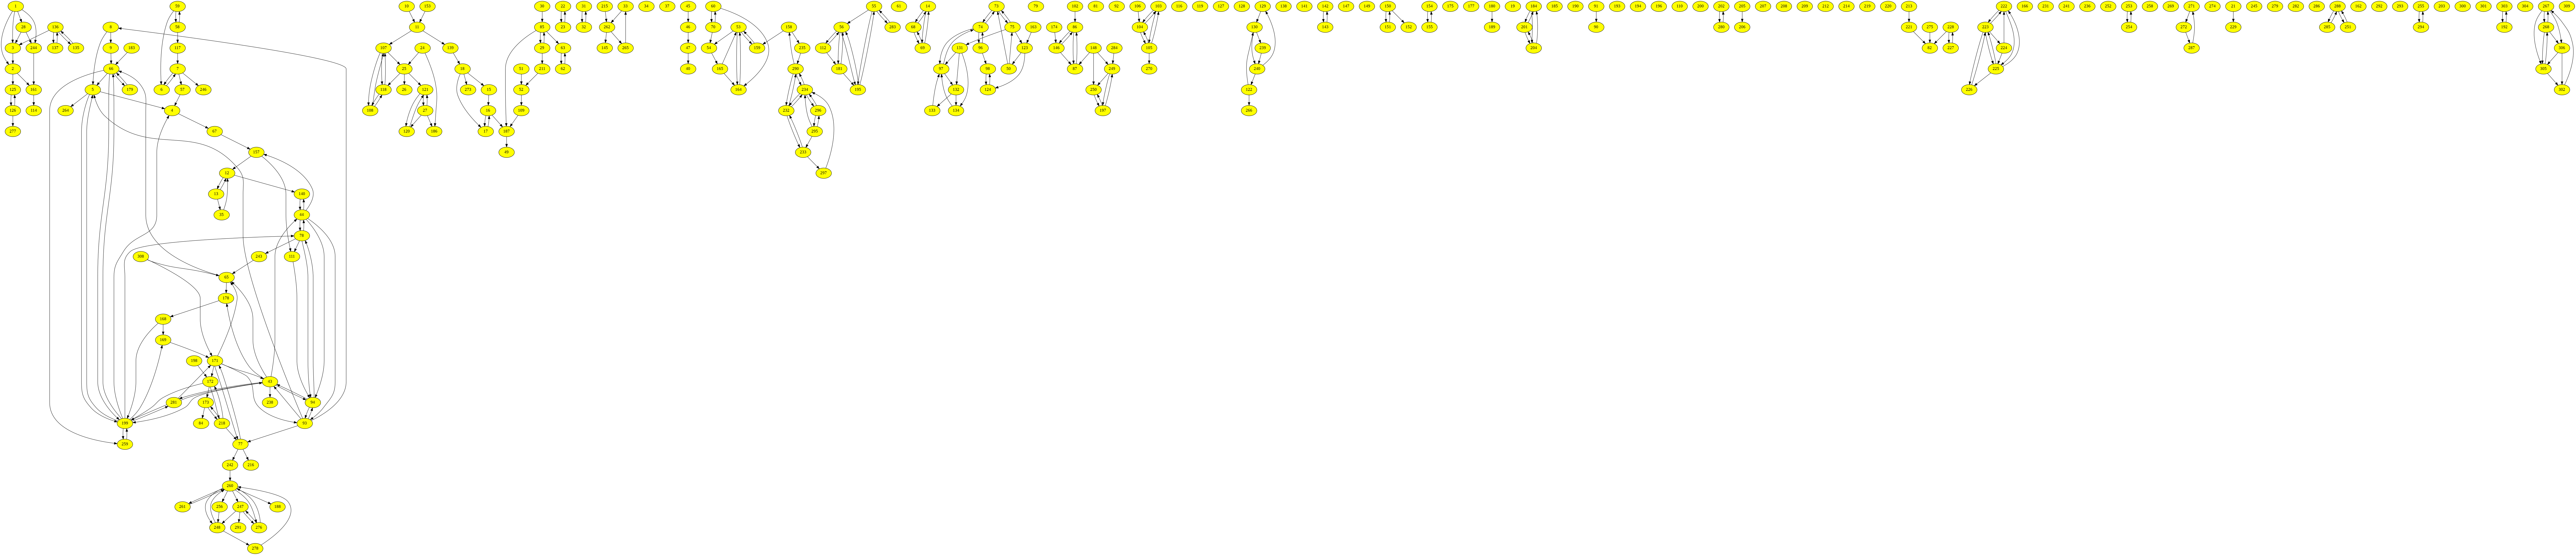

In [5]:
import pydot
import os
from IPython.display import Image, display
vertex=set()
a=-1
i=0
G1=pydot.Dot(graph_type="digraph")
G=pydot.Dot(graph_type="digraph")
for t in tr_seqs:
   i=0
   if len(t)>1:
      for p in t:
        if p not in vertex:
          vertex.add(p)
          node = pydot.Node(p, style="filled", fillcolor="yellow")
          G.add_node(node)
        if(i==0):
          a=p
          i=1
        else:
          if(a!=p):    
              edge = pydot.Edge(a,p)
              G1.add_edge(edge)
              if edge in G.get_edge_list():
                  pass
              else:    
                  G.add_edge(edge)
          a=p 
im = Image(G.create_png())
display(im)